Este projeto destina-se a criar um sistema de detecção de fraude utilizando machine learning. Para isso, será utilizada uma base de dados do Kaggle chamada [Fraud Detection Example] (https://www.kaggle.com/gopalmahadevan/fraud-detection-example) e ela tem uma fração de dados do [PaySim](https://github.com/EdgarLopezPhD/PaySim), um simulador de dados financeiros feito exatamente para detecção de fraude.

**Colunas do dataset**

**step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
(caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência)

**amount** - valor da transação em moeda local.

**nameOrig** - cliente que iniciou a transação

**oldbalanceOrg** - saldo inicial antes da transação

**newbalanceOrig** - novo saldo após a transação

**nameDest** - cliente que é o destinatário da transação

**oldbalanceDest** - destinatário do saldo inicial antes da transação. 
Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest** - novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud** - São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

**isFlaggedFraud** - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.


# Imports

In [39]:
# data wrangling
import pandas as pd
import pandas_profiling
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

# data balancing
from imblearn.over_sampling import SMOTE

# Get Data

In [2]:
df = pd.read_csv('fraud_dataset_example.csv')

In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [4]:
# vendo o nome das colunas
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Trazendo colunas de fraude para o começo do dataset

In [5]:
df = df[['isFraud','isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']]
df.head()

,isFraud,isFlaggedFraud,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Renomeando as colunas

In [6]:
# Criando o dicionário com as colunas
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [7]:
# renomeando colunas
df = df.rename(columns = colunas)
df.head()

,fraude,super_fraude,tempo,tipo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2
0,0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,0,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,0,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,0,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,0,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


# Outras informações do dataset

In [8]:
# analisando estatísticas das variáveis numéricas
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
fraude,101613.0,0.00,0.03,0.00,0.00,0.00,0.00,1.00
super_fraude,101613.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
tempo,101613.0,8.52,1.82,1.00,8.00,9.00,10.00,10.00
valor,101613.0,174090.07,345019.90,0.32,10016.59,53385.41,212498.40,10000000.00
saldo_inicial_c1,101613.0,907175.26,2829575.28,0.00,0.00,20190.47,194715.00,38939424.03
novo_saldo_c1,101613.0,923499.25,2867318.71,0.00,0.00,0.00,219217.76,38946233.02
saldo_inicial_c2,101613.0,881042.80,2399949.06,0.00,0.00,21058.00,591921.70,34008736.98
novo_saldo_c2,101613.0,1183998.10,2797761.08,0.00,0.00,51783.43,1063121.64,38946233.02


In [9]:
df.shape

(101613, 11)

In [10]:
# verificando se há dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


# Verificando a variável target

In [11]:
df2 = df.groupby(by = 'fraude').agg({'tempo':'count'}).reset_index()

# Calculating Percentage
df2['percent'] = ((df2['tempo'] / 
                  df2['tempo'].sum()) * 100).round(2)
df2.head()

,fraude,tempo,percent
0,0,101497,99.89
1,1,116,0.11


Apenas 0.11% dos dados da base advém de fraudes.

# Encoding

In [13]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Encoding

In [ ]:
# transformando a coluna categórica de tipo em colunas com variáveis numéricas
df = pd.get_dummies(data = df, columns = ['tipo'])

In [15]:
df.head()

,fraude,super_fraude,tempo,valor,cliente1,saldo_inicial_c1,novo_saldo_c1,cliente2,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0
1,0,0,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0
2,1,0,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,0,0,0,1
3,1,0,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1,0,0,0
4,0,0,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0


# Removendo variáveis

Não houve nenhuma super fraude, logo, essa coluna deve ser removida.

In [17]:
df = df.drop(columns = ['cliente1', 'cliente2', 'super_fraude'])

In [20]:
df.head()

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


# Regressão Logística

In [22]:
# dividindo o dataframe e a variável target
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [24]:
# dividindo entre dados de treino e dados de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [27]:
# instanciando o modelo de regressão logística
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# treinando o modelo
lr.fit(x_train, y_train)
# definindo a predição
y_pred = lr.predict(x_test)

# Métricas do modelo

In [28]:
# analisando a acurácia (avalia a quantidade de acertos)
print('Acurácia: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analisando a precisão (quantidade de verdadeiros positivos, quantas fraudes ocorrem)
print('Precisão: {}'.format(metrics.precision_score(y_test, y_pred)))
# analisando o recall (avalia a capacidade do modelo classificar corretamente as classes)
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analisando o F1 score (media harmônica entre a precisão e o recall)
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Acurácia: 0.9989765391276965
Precisão: 0.2
Recall: 0.043478260869565216
F1 Score: 0.07142857142857142


# Matriz de confusão

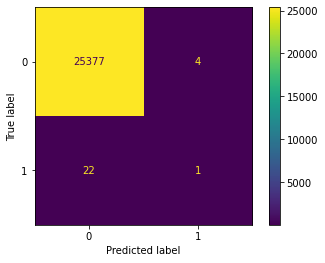

In [32]:
# criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# plottando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

As classes estão desbalanceadas, pois há muito mais dados em uma classe (daqueles que não realizaram fraude) em comparação as ocorrências de fraude.

# Curva ROC

In [34]:
# instanciando as métricas da curva ROC
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

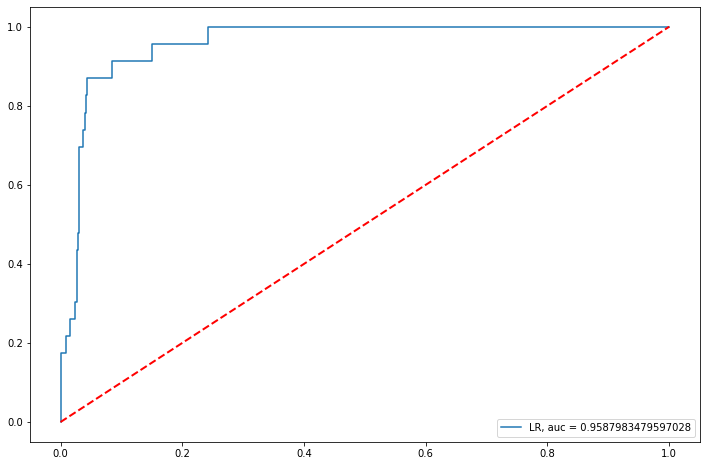

In [36]:
# plottando
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)

A curva ROC mostra que as classes estão desbalanceadas pois a acurácia está muito alta, porém as outras métricas estão baixíssimas. Será preciso balancear o dataset.

# Balanceamento dos dados

In [40]:
# instanciando o smote
smote = SMOTE(random_state = 42)

In [41]:
# retirando a variável target do dataframe
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [43]:
# criando variáveis balanceadas
x_resampled, y_resampled = smote.fit_resample(x, y)

In [46]:
# unindo as partes resampled em um único dataframe
df_balanced = pd.concat([y_resampled, x_resampled], axis = 1)

In [48]:
df_balanced

,fraude,tempo,valor,saldo_inicial_c1,novo_saldo_c1,saldo_inicial_c2,novo_saldo_c2,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
0,0,1,9839.640000,170136.000000,160296.36,0.000000,0.000000,0,0,0,1,0
1,0,1,1864.280000,21249.000000,19384.72,0.000000,0.000000,0,0,0,1,0
2,1,1,181.000000,181.000000,0.00,0.000000,0.000000,0,0,0,0,1
3,1,1,181.000000,181.000000,0.00,21182.000000,0.000000,0,1,0,0,0
4,0,1,11668.140000,41554.000000,29885.86,0.000000,0.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202989,1,5,17608.962863,17608.962863,0.00,0.000000,0.000000,0,0,0,0,1
202990,1,7,12116.291013,12116.291013,0.00,0.000000,0.000000,0,0,0,0,1
202991,1,1,231612.880715,231612.880715,0.00,1945.589357,9370.603471,0,0,0,0,0
202992,1,9,547325.144758,547325.144758,0.00,0.000000,0.000000,0,0,0,0,1


In [50]:
df_balanced.groupby(by = 'fraude').agg({'tempo':'count'})

,tempo
fraude,
0,101497
1,101497


Agora a label target está balanceada.

# Novo teste da Regressão Logística

In [51]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)

lr = LogisticRegression(max_iter=1000, random_state = 42)

lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


Embora a acurácia tenha diminuído, as outras métricas aumentaram bastante, tornando assim o resultado mais confiável.

# Matriz de confusão e curva ROC para o modelo com dados balanceados

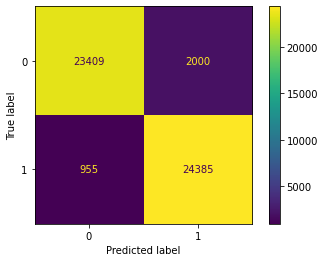

In [55]:
# criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# plottando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

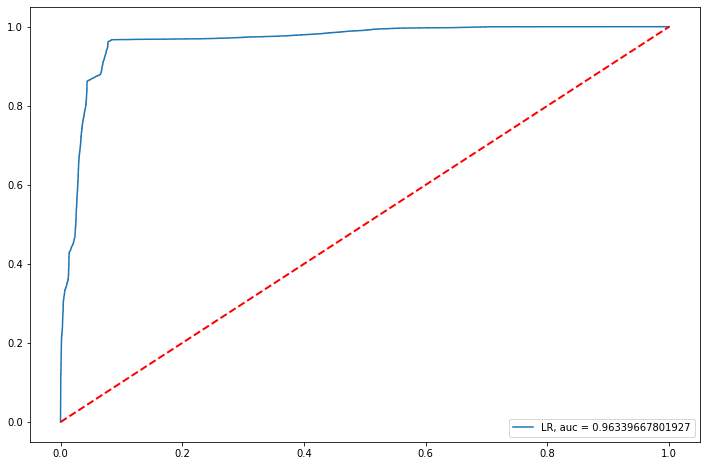

In [57]:
# instanciando as métricas da curva ROC
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plottando
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)